### Import Libaries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer
import xgboost as xgb

### Bring/Transform Data 

In [69]:
start_date = '2022-01-01'
# today_date = datetime.today().strftime('%Y-%m-%d')
# print(f"the data span from {start_date} up to {today_date}")

# fed effective interest rate
fed_rates = pd.read_excel('data/fed_eff_rate_2010-24.xlsx',sheet_name='Daily, 7-Day')
fed_rates.columns = ['date','rate']
fed_rates['date'] = pd.to_datetime(fed_rates['date'])
fed_rates['rate_change'] = fed_rates['rate'].diff()
fed_rates.head()
fed_rates = fed_rates.query('date > @start_date')

# EURO USD 
eurusd = yf.download('EURUSD=X', start=start_date)
eurusd = eurusd.reset_index()
eurusd.columns = ['date','open','high','low','eurusd_close','Adj Close','Volume']
eurusd = eurusd[['date','eurusd_close']]
eurusd.head()
eurusd['eurusd_change'] = eurusd['eurusd_close'].diff()

usdyen = yf.download('JPY=X', start=start_date)
usdyen = usdyen.reset_index()
usdyen.columns = ['date','open','high','low','usdyen_close','Adj Close','Volume']
usdyen = usdyen[['date','usdyen_close']]
usdyen.head()
usdyen['usdyen_change'] = usdyen['usdyen_close'].diff()

# zf 
df = yf.download('ZF=F', start=start_date)
df.reset_index(inplace=True)

# unemployment monthly 
unemployment_rate = pd.read_excel('data/UNRATE.xlsx', 'Monthly')
unemployment_rate.columns = ['date','un_rate']
unemployment_rate['date'] = pd.to_datetime(unemployment_rate['date'])
unemployment_rate = unemployment_rate.set_index('date').resample('D').ffill().reset_index()
unemployment_rate['un_change'] = unemployment_rate['un_rate'].diff()

### vix
vix = yf.download('^VIX', start=start_date)
vix.reset_index(inplace=True)
vix['vix_change'] = vix['Close'].diff()
vix = vix[['Date','vix_change','Close']]
vix.columns = ['date','vix_change','vix_close']

# snp500
sp500 = yf.download('^GSPC', start=start_date)
sp500.reset_index(inplace=True)
sp500.to_csv('sp500.csv',index_label=False)
sp500['sp500_change'] = sp500['Close'].diff()
sp500 = sp500[['Date','sp500_change','Close']]
sp500.columns = ['date','sp500_change','sp500_close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [70]:
df.columns = ['date','open','high','low','close','close_x','zf_volume']
del df['close_x']

### Feature Engineering

In [71]:
# candle stick features 
df['high_low'] = df['high'] - df['low']
df['body'] = df['close'] - df['open']
df['zf_change'] = df['close'].diff()
df['zf_change_pct'] = df['zf_change'] * 100

# Calendar features
df["day_of_week"] = df['date'].dt.dayofweek
df["day_of_month"] = df['date'].dt.day
df["week_of_year"] = df['date'].dt.isocalendar().week
df["month"] = df['date'].dt.month
df["year"] = df['date'].dt.year
df["quarter"] = df['date'].dt.quarter
df["is_month_end"] = df['date'].dt.is_month_end.astype(int)
df["is_month_start"] = df['date'].dt.is_month_start.astype(int)

# target 
df['tomorrow'] = df['close'].shift(-1)
df['target'] = (df['tomorrow'] > df['close']).astype(int)

In [72]:
df.head()

,date,open,high,low,close,zf_volume,high_low,body,zf_change,zf_change_pct,day_of_week,day_of_month,week_of_year,month,year,quarter,is_month_end,is_month_start,tomorrow,target
0,2022-01-03,120.875000,120.890625,120.421875,120.437500,907964,0.468750,-0.437500,NaN,NaN,0,3,1,1,2022,1,0,0,120.429688,0
1,2022-01-04,120.507812,120.546875,120.320312,120.429688,949320,0.226562,-0.078125,-0.007812,-0.78125,1,4,1,1,2022,1,0,0,120.117188,0
2,2022-01-05,120.500000,120.539062,120.085938,120.117188,1016140,0.453125,-0.382812,-0.312500,-31.25000,2,5,1,1,2022,1,0,0,119.867188,0
3,2022-01-06,120.132812,120.226562,119.843750,119.867188,1078231,0.382812,-0.265625,-0.250000,-25.00000,3,6,1,1,2022,1,0,0,119.734375,0
4,2022-01-07,119.898438,119.976562,119.632812,119.734375,1102805,0.343750,-0.164062,-0.132812,-13.28125,4,7,1,1,2022,1,0,0,119.562500,0


In [73]:
full_df = df.merge(fed_rates, on='date', how='left')
full_df = full_df.dropna()

In [74]:
full_df.target.value_counts()

0    397
1    349
Name: target, dtype: int64

In [75]:
## merge datasets 
full_df = full_df.merge(eurusd, on='date',how='left')
full_df = full_df.merge(usdyen, on='date',how='left')
full_df = full_df.merge(unemployment_rate,on='date',how='left')
full_df = full_df.merge(sp500, on='date',how='left')
full_df = full_df.merge(vix, on='date',how='left')
full_df['is_rate_change'] =  (full_df['rate_change'] != full_df['rate_change'].shift()).astype(int)
full_df['is_rate_change'] = full_df['is_rate_change'].rolling(window=5, center=True, min_periods=1).max().astype(int)
full_df['is_un_change'] = (full_df['un_change'] != full_df['un_change'].shift()).astype(int)
full_df['is_un_change'] = full_df['is_un_change'].rolling(window=5, center=True, min_periods=1).max().astype(int)


In [76]:
full_df, ohcl_predictors = create_ohlc_features(full_df)


/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_7138/2654380967.py:6: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  rolling_averages = df.rolling(horizon).mean()
/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_7138/2654380967.py:6: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  rolling_averages = df.rolling(horizon).mean()
/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_7138/2654380967.py:6: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dro

### Modeling

In [77]:
full_df.columns

Index(['date', 'open', 'high', 'low', 'close', 'zf_volume', 'high_low', 'body',
       'zf_change', 'zf_change_pct', 'day_of_week', 'day_of_month',
       'week_of_year', 'month', 'year', 'quarter', 'is_month_end',
       'is_month_start', 'tomorrow', 'target', 'rate', 'rate_change',
       'eurusd_close', 'eurusd_change', 'usdyen_close', 'usdyen_change',
       'un_rate', 'un_change', 'sp500_change', 'sp500_close', 'vix_change',
       'vix_close', 'is_rate_change', 'is_un_change', 'Close_Ratio_2',
       'Trend_2', 'Volatility_2', 'Momentum_2', 'Cumulative_Return_2',
       'Close_Ratio_3', 'Trend_3', 'Volatility_3', 'Momentum_3',
       'Cumulative_Return_3', 'Close_Ratio_4', 'Trend_4', 'Volatility_4',
       'Momentum_4', 'Cumulative_Return_4', 'Close_Ratio_5', 'Trend_5',
       'Volatility_5', 'Momentum_5', 'Cumulative_Return_5', 'Close_Ratio_10',
       'Trend_10', 'Volatility_10', 'Momentum_10', 'Cumulative_Return_10',
       'Close_Ratio_15', 'Trend_15', 'Volatility_15', 'Momen

In [78]:
full_df = full_df.dropna()

full_df.shape

(622, 89)

In [79]:
predictors = ['high_low', 'body', 'zf_change',
       'zf_change_pct', 'zf_volume','day_of_week', 'day_of_month', 'week_of_year', 'month',
       'year', 'quarter', 'is_month_end', 'is_month_start',
        'rate', 'rate_change', 'eurusd_change','eurusd_close','usdyen_close','usdyen_change', 'un_rate',
       'un_change','sp500_change','sp500_close',
#               'is_rate_change',
#               'is_un_change',
              'vix_change','vix_close']
predictors = predictors + ohcl_predictors
target = 'target'

In [80]:
predictors

['high_low',
 'body',
 'zf_change',
 'zf_change_pct',
 'zf_volume',
 'day_of_week',
 'day_of_month',
 'week_of_year',
 'month',
 'year',
 'quarter',
 'is_month_end',
 'is_month_start',
 'rate',
 'rate_change',
 'eurusd_change',
 'eurusd_close',
 'usdyen_close',
 'usdyen_change',
 'un_rate',
 'un_change',
 'sp500_change',
 'sp500_close',
 'vix_change',
 'vix_close',
 'Close_Ratio_2',
 'Trend_2',
 'Volatility_2',
 'Momentum_2',
 'Cumulative_Return_2',
 'Close_Ratio_3',
 'Trend_3',
 'Volatility_3',
 'Momentum_3',
 'Cumulative_Return_3',
 'Close_Ratio_4',
 'Trend_4',
 'Volatility_4',
 'Momentum_4',
 'Cumulative_Return_4',
 'Close_Ratio_5',
 'Trend_5',
 'Volatility_5',
 'Momentum_5',
 'Cumulative_Return_5',
 'Close_Ratio_10',
 'Trend_10',
 'Volatility_10',
 'Momentum_10',
 'Cumulative_Return_10',
 'Close_Ratio_15',
 'Trend_15',
 'Volatility_15',
 'Momentum_15',
 'Cumulative_Return_15',
 'Close_Ratio_20',
 'Trend_20',
 'Volatility_20',
 'Momentum_20',
 'Cumulative_Return_20',
 'Close_Ratio_3

In [81]:
# Convert categorical columns to numeric or use `enable_categorical=True`
# X = full_df[predictors].copy()
# y = full_df[target]
X = full_df.copy()
X = X.query('is_rate_change == 1 or is_un_change==1')
# del X['is_rate_change'], X['is_un_change']
for col in X.columns:
    if X[col].dtype.name not in ['int64', 'float64', 'bool']:
        if pd.api.types.is_categorical_dtype(X[col]) or pd.api.types.is_object_dtype(X[col]):
            X[col] = X[col].astype('category').cat.codes  # Convert to category codes
        elif pd.api.types.is_datetime64_any_dtype(X[col]):  # Handle datetime columns
            # Example: Convert datetime to a numeric format (e.g., timestamp)
            X[col] = X[col].astype('int64') // 10**9  # Convert to seconds since epoch
        else:
            X[col] = X[col].astype('float64')  # Convert UInt32 or others to float

In [82]:
X.shape

(179, 89)

### XGBoost

In [87]:
# # Splitting data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train XGBoost Classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# model.fit(X_train, y_train)

# # Predictions and Precision
# y_pred = model.predict(X_test)
# precision = precision_score(y_test, y_pred)
# print(f"Precision: {precision}")

predictions = backtest(X, model, predictors)
precision_score(predictions["target"], predictions["Predictions"])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


0.5625

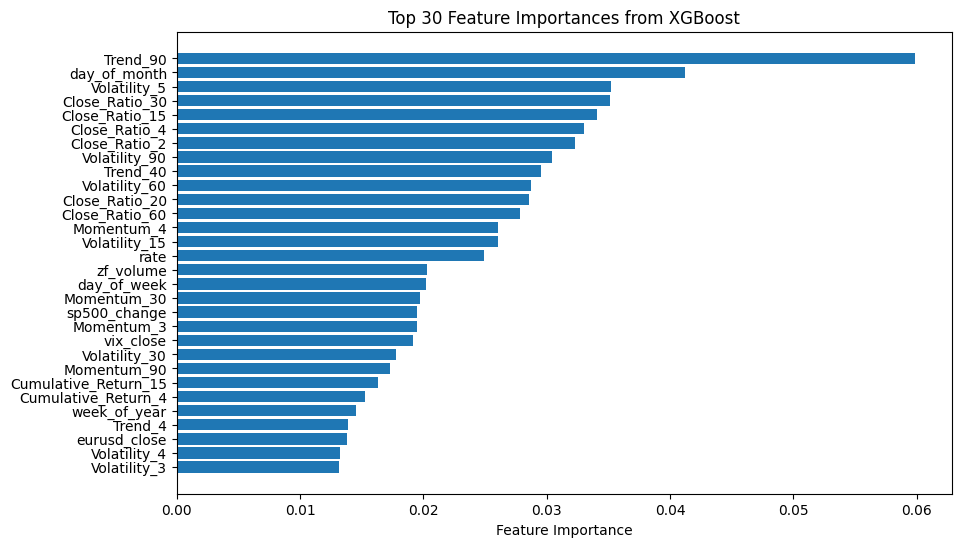

In [88]:
# Feature Importances
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

# Select the top 15 features
top_n = 30
top_features = sorted_idx[:top_n]

plt.figure(figsize=(10, 6))
plt.barh([predictors[i] for i in top_features], importances[top_features])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Feature Importances from XGBoost")
plt.gca().invert_yaxis()
plt.show()

In [89]:
predictions["target"].value_counts() / predictions.shape[0]

1    0.517241
0    0.482759
Name: target, dtype: float64

### Feature Selection

In [90]:
# Perform iterative feature selection
step_size = 10
results_df, selected_features = iterative_feature_selection(X, model, predictors, step_size)

# Display results
print(results_df)

Step: 10, Precision: 0.5454545454545454
Step: 20, Precision: 0.38461538461538464
Step: 30, Precision: 0.5294117647058824
Step: 40, Precision: 0.5882352941176471
Step: 50, Precision: 0.5714285714285714
Step: 60, Precision: 0.4666666666666667
Step: 70, Precision: 0.5294117647058824
Step: 80, Precision: 0.5294117647058824
   Num Features  Precision
0            10   0.545455
1            20   0.384615
2            30   0.529412
3            40   0.588235
4            50   0.571429
5            60   0.466667
6            70   0.529412
7            80   0.529412


In [91]:
selected_features.sort_values(ascending=False, by='Average_Importance').head(80)

,Feature,Importance,Cumulative_Importance,Counts,Average_Importance
55,Close_Ratio_20,0.029949,0.569622,8,0.071203
13,rate,0.054827,0.484183,8,0.060523
38,Momentum_4,0.019811,0.412872,7,0.058982
35,Close_Ratio_4,0.037364,0.466573,8,0.058322
52,Volatility_15,0.028228,0.383091,8,0.047886
...,...,...,...,...,...
49,Cumulative_Return_10,0.000000,0.000000,1,0.000000
9,year,0.000000,0.000000,2,0.000000
11,is_month_end,0.000000,0.000000,1,0.000000
14,rate_change,0.000000,0.000000,1,0.000000


### Helpers

In [86]:
def create_ohlc_features(df, horizons=[2,3,4,5,10, 15,20,30,40,60,90]):
    predictors = []

    for horizon in horizons:
        # Rolling averages and ratios
        rolling_averages = df.rolling(horizon).mean()
        df[f"Close_Ratio_{horizon}"] = df["close"] / rolling_averages["close"]
        # Trend (cumulative sum of target over horizon)
        df[f"Trend_{horizon}"] = df["target"].shift(1).rolling(horizon).sum()

        # Volatility (rolling standard deviation)
        df[f"Volatility_{horizon}"] = df["close"].rolling(horizon).std()

        # Momentum (difference between current and lagged price)
        df[f"Momentum_{horizon}"] = df["close"] - df["close"].shift(horizon)


        # Cumulative Return
        df[f"Cumulative_Return_{horizon}"] = df["close"].pct_change().rolling(horizon).sum()

        # Add features to the predictor list
        predictors += [
            f"Close_Ratio_{horizon}",
            f"Trend_{horizon}",
            f"Volatility_{horizon}",
            f"Momentum_{horizon}",
            f"Cumulative_Return_{horizon}",
        ]

    # Drop NA rows introduced by rolling and shifting, but only drop rows with all NaNs
    df = df.dropna(subset=predictors, how="all")

    return df, predictors


def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=150, step=20):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

def backtest_around_announcements(data, model, predictors, start=500, step=75):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Train and predict
        predictions = predict(train, test, predictors, model)
        predictions = predictions.join(data[["is_rate_change"]], how="left")
        predictions = predictions.join(data[["is_un_change"]], how="left")
        
        # Append all predictions for later evaluation
        all_predictions.append(predictions)
    
    # Combine results
    combined_predictions = pd.concat(all_predictions)
    
    # Filter only rows where is_rate_change == 1
#     announcement_predictions = combined_predictions[combined_predictions["is_rate_change"] == 1]
    announcement_predictions = combined_predictions.query('is_rate_change == 1 or is_un_change==1')
    return announcement_predictions


def iterative_feature_selection(data, model, predictors, step_size):
    # Fit the model to get initial feature importances
    model.fit(data[predictors], data["target"])
    initial_importances = model.feature_importances_
    
    # Create a DataFrame to hold aggregated feature importances
    feature_importance_df = pd.DataFrame({
        "Feature": predictors,
        "Importance": initial_importances
    }).set_index("Feature")
    feature_importance_df["Cumulative_Importance"] = 0
    feature_importance_df["Counts"] = 0

    # Iteratively evaluate features
    results = []
    step = step_size

    while step <= len(predictors):
        # Get the top `step` features
        top_features = feature_importance_df.sort_values(by="Importance", ascending=False).index[:step].tolist()

        # Backtest with the selected features
        predictions = backtest(data, model, top_features)
        precision = precision_score(predictions["target"], predictions["Predictions"])

        # Update feature importances for the current top features
        model.fit(data[top_features], data["target"])
        current_importances = model.feature_importances_
        for feature, importance in zip(top_features, current_importances):
            feature_importance_df.loc[feature, "Cumulative_Importance"] += importance
            feature_importance_df.loc[feature, "Counts"] += 1

        # Store results
        results.append({"Num Features": step, "Precision": precision})
        print(f"Step: {step}, Precision: {precision}")
        
        # Increment the step size
        step += step_size

    # Finalize aggregated importances
    feature_importance_df["Average_Importance"] = (
        feature_importance_df["Cumulative_Importance"] / feature_importance_df["Counts"]
    ).fillna(0)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df, feature_importance_df.reset_index()
